# Loop Hydrodynamics: Out-of-Phase Cooling

In [39]:
import os
import subprocess
import multiprocessing

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import synthesizAR
from synthesizAR.interfaces import EbtelInterface
from synthesizAR.util import InputHandler

%matplotlib inline

In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

Construct a heating model where each loop is heated once, but the loops are out of phase. We'll construct the uniform distribution such that all the events are at least allowed to finish. However, note that shorter loops are more likely to complete their full heating-and-cooling cycle as they have shorter cooling times.

In [3]:
class OutofPhaseNanoflares(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        
    def calculate_event_properties(self,loop):
        self.number_events = 1
        start_time = np.random.uniform(low=0, high=self.base_config['total_time'] - self.heating_options['duration'])
        max_energy = (self.heating_options['stress_level'] * loop.field_strength.mean().value)**2/(8.*np.pi)
        return {'magnitude':[max_energy/(self.heating_options['duration']/2.)],
                'rise_start':[start_time],
                'rise_end':[start_time+self.heating_options['duration']/2],
                'decay_start':[start_time+self.heating_options['duration']/2],
                'decay_end':[start_time+self.heating_options['duration']]}

In [4]:
heating_options = {
    'duration':200.0,
    'stress_level':0.3,
}
heating_model = OutofPhaseNanoflares(heating_options)

In [5]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 1e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [7]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/hydro_config/',
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/hydro_results/')

In [8]:
field.configure_loop_simulations(ebtel_interface,)

FloatProgress(value=0.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


In [9]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [10]:
pool = multiprocessing.Pool()

In [11]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

In [12]:
pool.close()

In [13]:
field.load_loop_simulations(ebtel_interface,'/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/loop_parameters.h5')

FloatProgress(value=0.0)

Text(0.5,0,'$t$ [s]')

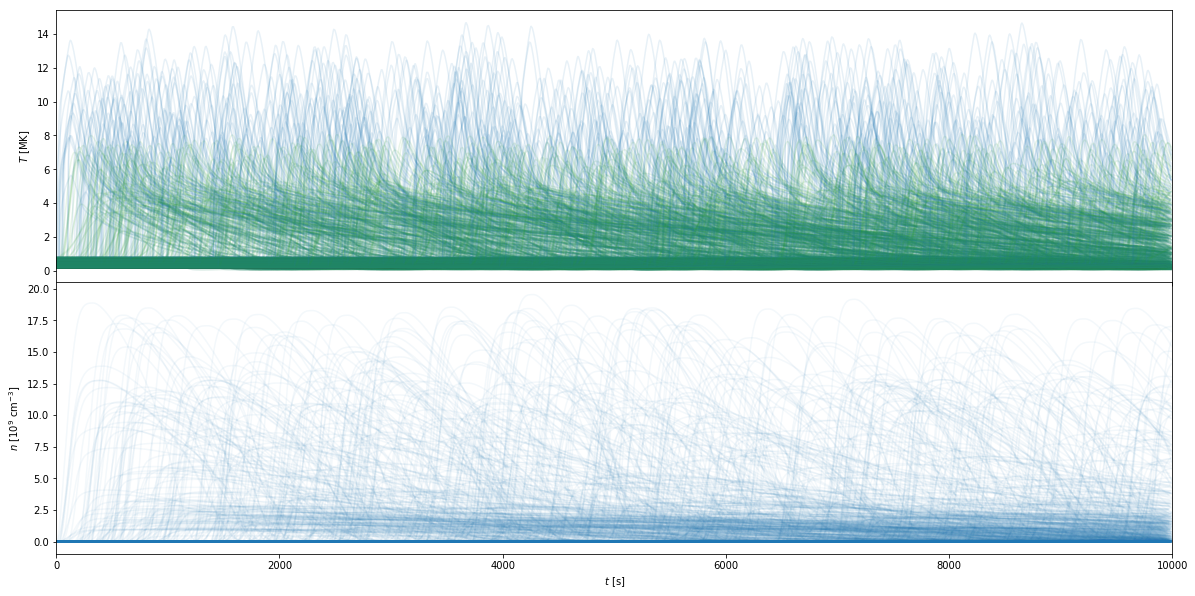

In [15]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::5]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.1)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.1)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.05)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [16]:
field.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/field_checkpoint/')

In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase/field_checkpoint/')

In [13]:
loop_lengths,cooling_times = [],[]
for l in field.loops:
    t_max = l.time[np.argmax(l.electron_temperature[:,0])]
    i_1MK = np.where(l.electron_temperature[:,0] > 1e6*u.K)[0]
    if len(i_1MK) == 0:
        continue
    t_1MK = l.time[i_1MK[-1]]
    if t_1MK == l.time[-1]:
        cooling_times.append(np.inf)
    else:
        cooling_times.append((t_1MK - t_max).to(u.s).value)
    loop_lengths.append(l.full_length.to(u.Mm).value)
loop_lengths = u.Quantity(loop_lengths, 'Mm')
cooling_times = u.Quantity(cooling_times, 's')

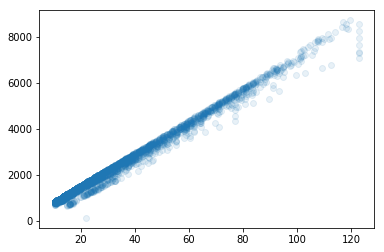

In [17]:
plt.plot(loop_lengths/2., cooling_times,'o',alpha=0.1)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


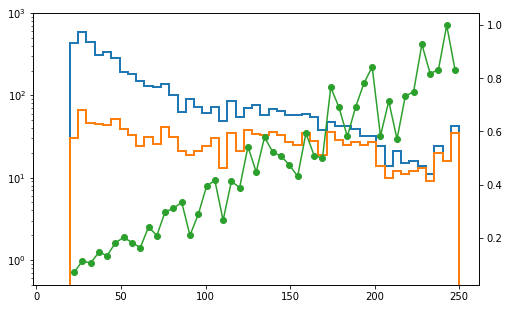

In [38]:
bins=np.linspace(10,250,50)
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.hist([l.full_length.to(u.Mm).value for l in field.loops],histtype='step',lw=2,color='C0',bins=bins,log=True);
ax.hist(loop_lengths[np.where(np.isinf(cooling_times))],histtype='step',lw=2,color='C1',bins=bins,log=True);
ax.set_ylim(0.5,1e3)
ax2 = ax.twinx()
h1,_ = np.histogram([l.full_length.to(u.Mm).value for l in field.loops],bins=bins,)
h2,_ = np.histogram(loop_lengths[np.where(np.isinf(cooling_times))],bins=bins)
ax2.plot((bins[1:]+bins[:-1])/2., 1 - (h1 - h2)/h1, '-o', color='C2')